Manipulation of <code>Call-receive-data.xlsx</code>.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ss = pd.read_excel('Call-receive-data.xlsx')

In [3]:
def was_abandoned(row):
    if pd.isnull(row['Abandon-time']):
        return False
    else:
        return True
    
ss['Abandoned'] = ss.apply(lambda r: was_abandoned(r), axis=1)

In [4]:
ss['Create time'] = pd.to_datetime(ss['Create time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')
ss['Accept time'] = pd.to_datetime(ss['Accept time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')
ss['Abandon-time'] = pd.to_datetime(ss['Abandon-time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')

In [5]:
ss['Total-time'] = ss['Total-time'].apply(lambda x: pd.to_timedelta(x, errors='ignore'))

In [6]:
ss.loc[~ss['Total-time'].isnull()].head()

,Period,Media,Channel,Queue,Transaction,Origination,Customer,Case Number,Web Callback,Create time,...,Voice mail left,IVR-Treatment-Time,Hold-Max,Hold-Count,Hold-Total,PDD-Leg 1,PDD-Leg 2,AT-Leg 1,AT-Leg 2,Abandoned
0,18/07/2020,Email,customerservices@peoplesenergy.co.uk,Cancellations (2h),657601.0,keith.m.rowling@gmail.com,"(last name not available), Switchcraft",169337.2,NaN,2020-07-18 07:06:07,...,NaN,00:00:00,00:00:00,0.0,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,False
1,18/07/2020,Email,customerservices@peoplesenergy.co.uk,Cancellations (2h),657686.0,kay.upcott@icloud.com,"Upcott, Kay",168705.2,NaN,2020-07-18 07:56:51,...,NaN,00:00:00,00:00:00,0.0,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,False
2,18/07/2020,Email,customerservices@peoplesenergy.co.uk,Cancellations (2h),657705.0,kezp1@hotmail.co.uk,"PRICE, KELLY",170233.0,NaN,2020-07-18 08:02:12,...,NaN,00:00:00,00:00:00,0.0,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,False
3,18/07/2020,Email,customerservices@peoplesenergy.co.uk,Cancellations (2h),657732.0,cazsheru63@hotmail.co.uk,"kelly, caroline",170245.0,NaN,2020-07-18 08:11:37,...,NaN,00:00:00,00:00:00,0.0,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,False
5,18/07/2020,Email,customerservices@peoplesenergy.co.uk,Cancellations (2h),657768.0,collisaugustine1303@gmail.com,"Augustine, Collis",170267.0,NaN,2020-07-18 08:21:28,...,NaN,00:00:00,00:00:00,0.0,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,False


In [7]:
def calc_abandon_time(row):
    if row['Abandoned']:
        return row['Abandon-time'] - row['Create time']      
    else:
        return None

ss['Abandoned-after'] = ss[['Create time', 'Abandon-time', 'Abandoned']].apply(lambda r: calc_abandon_time(r), axis=1)

In [8]:
ss.rename(columns={'Create time': 'Create-time', 'Accept time': 'Accept-time'}, inplace=True)

We want to create a fresh dataframe not a view of <code>ss</code>.

In [9]:
attrs_of_interest = ['Period', 'Create-time', 'Agent', 'Accept-time', 'Total-time', 'Abandon-time', 'Abandoned', 'Abandoned-after']
data = ss.loc[:, attrs_of_interest]

In [10]:
data['time-to-accept'] = data.apply(lambda r: r['Accept-time'] - r['Create-time'], axis=1)

This is an **important** step. We group all calls in an interval of $5$ minutes.

In [12]:
inflow = data[['Create-time', 'Agent']].groupby(pd.Grouper(key='Create-time', freq='5min')).count()
inflow.reset_index(inplace=True)

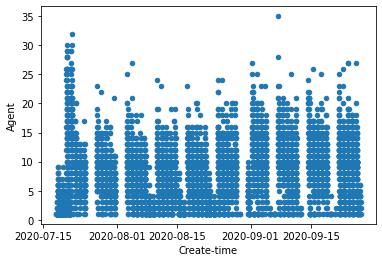

In [13]:
ignore = inflow.loc[inflow['Agent'] > 0].plot.scatter(x='Create-time', y='Agent')

In [14]:
inflow.iloc[inflow['Agent'].idxmax()]

Create-time    2020-09-07 09:20:00
Agent                           35
Name: 14800, dtype: object

In [15]:
inflow.head()

,Create-time,Agent
0,2020-07-18 00:00:00,0
1,2020-07-18 00:05:00,0
2,2020-07-18 00:10:00,1
3,2020-07-18 00:15:00,0
4,2020-07-18 00:20:00,0


In [16]:
inflow.rename(columns = {'Agent': 'ncalls'}, inplace=True)

In [17]:
inflow.head()

,Create-time,ncalls
0,2020-07-18 00:00:00,0
1,2020-07-18 00:05:00,0
2,2020-07-18 00:10:00,1
3,2020-07-18 00:15:00,0
4,2020-07-18 00:20:00,0


In [18]:
inflow.to_csv('full-inflow.csv', index=False)

In [19]:
inflow.dtypes

Create-time    datetime64[ns]
ncalls                  int64
dtype: object

In [20]:
data.dtypes

Period                      object
Create-time         datetime64[ns]
Agent                       object
Accept-time         datetime64[ns]
Total-time                  object
Abandon-time        datetime64[ns]
Abandoned                     bool
Abandoned-after    timedelta64[ns]
time-to-accept     timedelta64[ns]
dtype: object

In [21]:
data['Total-time'] = data['Total-time'].apply(lambda r: (r.hour*60 + r.minute)*60 + r.second)
total_time = data[['Create-time', 'Total-time']].groupby(pd.Grouper(key='Create-time', freq='5min')).mean()
total_time.reset_index(inplace=True)
total_time.rename(columns={'Total-time': 'Avg-time'}, inplace=True)
total_time.head()

,Create-time,Avg-time
0,2020-07-18 00:00:00,NaN
1,2020-07-18 00:05:00,NaN
2,2020-07-18 00:10:00,13.0
3,2020-07-18 00:15:00,NaN
4,2020-07-18 00:20:00,NaN


In [22]:
total_time.loc[~total_time['Avg-time'].isnull()].head()

,Create-time,Avg-time
2,2020-07-18 00:10:00,13.0
12,2020-07-18 01:00:00,245.0
15,2020-07-18 01:15:00,16.0
25,2020-07-18 02:05:00,11.0
35,2020-07-18 02:55:00,16.0


In [23]:
total_time.to_csv('total_time.csv', index=False)

In [24]:
consolidated = pd.merge(left=inflow, right=total_time, on='Create-time')

In [25]:
consolidated.head()

,Create-time,ncalls,Avg-time
0,2020-07-18 00:00:00,0,NaN
1,2020-07-18 00:05:00,0,NaN
2,2020-07-18 00:10:00,1,13.0
3,2020-07-18 00:15:00,0,NaN
4,2020-07-18 00:20:00,0,NaN


In [26]:
consolidated.dtypes

Create-time    datetime64[ns]
ncalls                  int64
Avg-time              float64
dtype: object

In [29]:
type(ss['Period'][0])

str

In [44]:
def extract_period(dt):
    return str(dt)[0:10]    

consolidated['Period'] = consolidated.apply(lambda r: extract_period(r['Create-time']), axis=1)

In [45]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period
0,2020-07-18 00:00:00,0,NaN,2020-07-18
1,2020-07-18 00:05:00,0,NaN,2020-07-18
2,2020-07-18 00:10:00,1,13.0,2020-07-18
3,2020-07-18 00:15:00,0,NaN,2020-07-18
4,2020-07-18 00:20:00,0,NaN,2020-07-18


In [36]:
nagents = ss[['Period', 'Agent']].groupby('Period').nunique()
nagents.reset_index(inplace=True)

In [37]:
nagents.head()

,Period,Agent
0,01/09/2020,53
1,02/09/2020,49
2,03/08/2020,46
3,03/09/2020,44
4,04/08/2020,45


In [39]:
type(nagents['Period'][0])

str

In [40]:
def convert(d):
    yr = d[6:10]
    mn = d[3:5]
    dy = d[0:2]
    
    return yr + '-' + mn + '-' + dy


In [46]:
nagents['Period'] = nagents.apply(lambda r: convert(r['Period']), axis=1)

In [47]:
nagents.head()

,Period,Agent
0,2020-09-01,53
1,2020-09-02,49
2,2020-08-03,46
3,2020-09-03,44
4,2020-08-04,45


In [48]:
consolidated = pd.merge(left=consolidated, right=nagents, on='Period')

In [50]:
consolidated.rename(columns={'Agent': 'nagents'}, inplace=True)

In [51]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period,nagents
0,2020-07-18 00:00:00,0,NaN,2020-07-18,56
1,2020-07-18 00:05:00,0,NaN,2020-07-18,56
2,2020-07-18 00:10:00,1,13.0,2020-07-18,56
3,2020-07-18 00:15:00,0,NaN,2020-07-18,56
4,2020-07-18 00:20:00,0,NaN,2020-07-18,56


In [52]:
consolidated.to_csv('consolidated.csv', index=False)

In [60]:
nagents = nagents[nagents.Period.str.contains('2020')] # Two extraneous rows showing up.

In [62]:
nagents['Date'] = pd.to_datetime(nagents['Period'], format='%Y-%m-%d')

In [67]:
nagents.sort_values('Date', inplace=True)

In [68]:
nagents[['Period', 'Agent']].to_csv('nagents.csv', index=False)